# Data Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
import json
import librosa
import soundfile as sf
import random
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

In [3]:
DATASET_NAME = 'DATASET_CNN'
DATASET_PATH = f'/home/giacomoschiavo/segments/{DATASET_NAME}'
AUDIO_SOURCE = '/home/giacomoschiavo/Tovanella'

In [4]:
DATASET_NAME = 'NEW_DATASET'
DATASET_PATH = f'E:/Giacomo/Tovanella/{DATASET_NAME}'
AUDIO_SOURCE = 'E:/Giacomo/Tovanella/Tovanella'

# Data division
How the segments are automatically split into training and test set

In [5]:
# LOAD
# with open("utils/species_date_count.json") as f:
#     species_date_count = json.load(f)

Get the count by date in each species

In [6]:
# get date count by species
target = f'{DATASET_PATH}/train'
species_date_count = {}
for specie in os.listdir(target):
    if target not in species_date_count:
        species_date_count[specie] = {}
    audio_names = os.listdir(os.path.join(target, specie))
    date_counts = { audio.split("_")[0]: 0 for audio in audio_names }
    for date in date_counts:
        species_date_count[specie][date] = { "count": sum(date in audio for audio in audio_names), "is_training": False}

In [ ]:
# with open(f"utils/{DATASET_NAME}/species_date_count.json", 'w') as f:
#     json.dump(species_date_count, f)

## How to split data in training and test set?
+ 1 date: ignore
+ Only 2 dates: minority -> test, majority -> training
+ More than 2 dates: take the majority and calculate the sum of all the other dates; if the sum is greater than half majority, move the biggest element in the minority into the majority and check again the sum

In [8]:
import copy
train_test_division = copy.deepcopy(species_date_count)
for specie in train_test_division.keys():
    dates = list(train_test_division[specie].keys())
    date_count = len(dates)
    values = [value["count"] for value in train_test_division[specie].values()]
    if date_count <= 1:     # ignore
        continue
    elif date_count == 2:
        greatest_date = dates[np.argmax(values)]
        train_test_division[specie][greatest_date]["is_training"] = True     # majority -> training
    else:
        greatest_value_index = np.argmax(values)
        greatest_value_date = dates[greatest_value_index]
        greatest_value = train_test_division[specie][greatest_value_date]["count"]
        train_test_division[specie][greatest_value_date]["is_training"] = True
        other_values = [ value["count"] if value["is_training"] == False else 0 for value in train_test_division[specie].values() ]
        sum_other_values = sum(other_values)
        while sum_other_values > greatest_value / 2:
            greatest_value_index = np.argmax(other_values)
            greatest_value_date = dates[greatest_value_index]
            train_test_division[specie][greatest_value_date]["is_training"] = True
            sum_other_values -= train_test_division[specie][greatest_value_date]["count"]

In [ ]:
# # SAVE
# with open(f"utils/{DATASET_NAME}/train_test_division.json", 'w') as f:
#     json.dump(train_test_division, f)

In [10]:
species_date_count["Certhia familiaris_Eurasian Treecreeper"], train_test_division["Certhia familiaris_Eurasian Treecreeper"]

({'20190603': {'count': 24, 'is_training': False},
  '20190608': {'count': 7, 'is_training': False},
  '20190621': {'count': 19, 'is_training': False},
  '20200217': {'count': 2, 'is_training': False}},
 {'20190603': {'count': 24, 'is_training': True},
  '20190608': {'count': 7, 'is_training': False},
  '20190621': {'count': 19, 'is_training': True},
  '20200217': {'count': 2, 'is_training': False}})

## Representation of the split

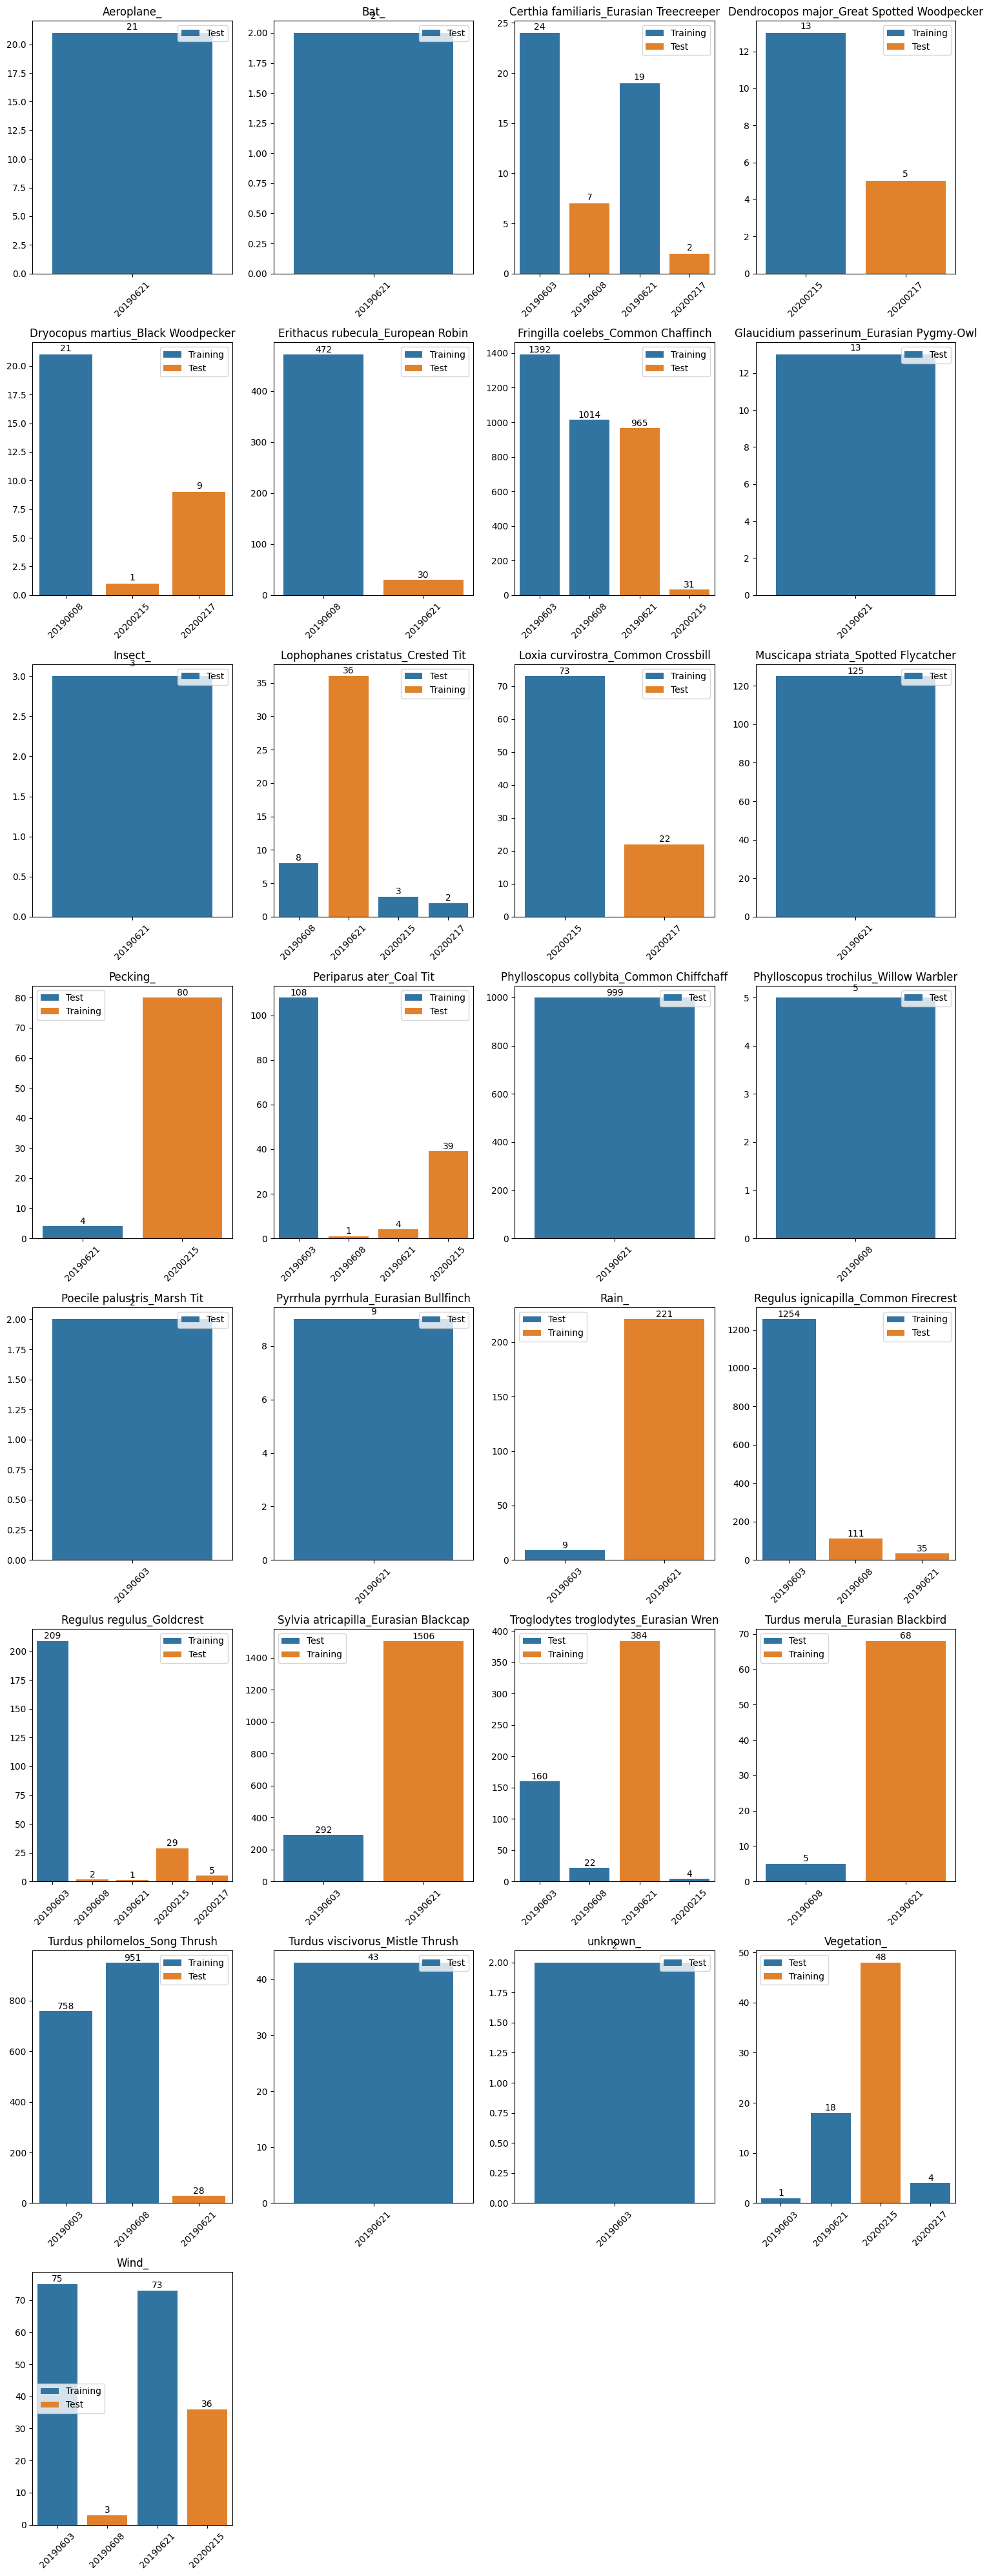

In [11]:

# Supponiamo che 'species_date_count' contenga i tuoi dati
n_species = len(train_test_division.keys())

cols = 4
rows = (n_species // cols) + (n_species % cols != 0) 

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, species in enumerate(train_test_division.keys()):
    dates = list(train_test_division[species].keys())
    counts = [ value["count"] for value in train_test_division[species].values()]
    is_training = [ "Training" if value["is_training"] else "Test" for value in train_test_division[species].values()]
    
    sns.barplot(x=dates, y=counts, ax=axes[i], hue=is_training)

    for j, count in enumerate(counts):
        axes[i].text(j, count + 0.1, str(count), ha='center', va='bottom')
    axes[i].set_title(species)
    axes[i].tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse x se necessario

for i in range(n_species, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()  # Aggiusta lo spazio tra i grafici
plt.show()


Here we move the segments from the source (all the segments divided by species) to the test set, as the species_date_count describes 

In [12]:
train_folder = f"{DATASET_PATH}/train"
test_folder = f"{DATASET_PATH}/test"
valid_folder = f"{DATASET_PATH}/valid"
removed = f"{DATASET_PATH}/removed"
os.makedirs(test_folder, exist_ok=True)
os.makedirs(removed, exist_ok=True)
for specie in os.listdir(train_folder):
    if len(train_test_division[specie]) <= 1:
        os.rename(
            os.path.join(train_folder, specie),
            os.path.join(removed, specie)
        )
        continue
    os.makedirs(os.path.join(test_folder, specie), exist_ok=True)
    for audio in os.listdir(os.path.join(train_folder, specie)):
        test_dates = [ date for date in train_test_division[specie].keys() 
                      if train_test_division[specie][date]["is_training"] == False ]
        audio_date = audio.split("_")[0]
        if audio_date in test_dates:
            os.rename(
                os.path.join(train_folder, specie, audio),
                os.path.join(test_folder, specie, audio)
            )

In [13]:
# # MOVE EVERYTHING BACK TO TRAINING
# train_folder = f"E:/Giacomo/Tovanella/{dataset_name}/train"
# test_folder = f"E:/Giacomo/Tovanella/{dataset_name}/test"
# valid_folder = f"E:/Giacomo/Tovanella/{dataset_name}/valid"
# removed = f"E:/Giacomo/Tovanella/{dataset_name}/removed"

# for species in os.listdir(test_folder):
#     for audio in os.listdir(os.path.join(test_folder, species)):
#         os.rename(
#             os.path.join(test_folder, species, audio),
#             os.path.join(train_folder, species, audio),
#         )
# for species in os.listdir(removed):
#     os.rename(
#         os.path.join(removed, species),
#         os.path.join(train_folder, species),
#     )

In [14]:
# SHOW DIVISION BY TRAINING, VALID and TEST
source = f"{DATASET_PATH}/train"
species_folders = os.listdir(source)
valid_folder = f"{DATASET_PATH}/valid"
os.makedirs(valid_folder, exist_ok=True)
dest = f"{DATASET_PATH}/test"
species_count = { folder: {
        "train_count": len(os.listdir(os.path.join(source, folder))),
        "valid_count": 0 if not os.path.exists(os.path.join(valid_folder, folder)) else len(os.listdir(os.path.join(valid_folder, folder))),    
        "test_count": len(os.listdir(os.path.join(dest, folder))),
    } for folder in species_folders if folder != "Noise" }
df = pd.DataFrame(species_count).T
df.sort_index(ascending=True)

,train_count,valid_count,test_count
Certhia familiaris_Eurasian Treecreeper,43,0,9
Dendrocopos major_Great Spotted Woodpecker,13,0,5
Dryocopus martius_Black Woodpecker,21,0,10
Erithacus rubecula_European Robin,472,0,30
Fringilla coelebs_Common Chaffinch,2406,0,996
Lophophanes cristatus_Crested Tit,36,0,13
Loxia curvirostra_Common Crossbill,73,0,22
Pecking_,80,0,4
Periparus ater_Coal Tit,108,0,44
Rain_,221,0,9


# Adding Noise data
Create a Noise folder for the BirdNET model with some noise taken from random audio

In [15]:
noise_folder = f"E:/Giacomo/Tovanella/{dataset_name}/train/Noise"
os.makedirs(noise_folder, exist_ok=True)

NameError: name 'dataset_name' is not defined

In [ ]:
# manually checked
safe_audio_for_noise = [
    '20190621_010000.WAV',
    '20190621_020000.WAV',
    '20190621_210000.WAV',
    '20200215_070000.WAV',
    '20200215_110000.WAV',
    '20200217_000000.WAV',
    '20200217_140000.WAV',
    '20200217_160000.WAV',
    '20190603_230000.WAV'
]
    

In [ ]:
# take 7 segments of 3s for every audio
orig_audio_path = "E:/Giacomo/Tovanella/Tovanella"
for audio_path in safe_audio_for_noise:
    audio = AudioSegment.from_file(os.path.join(orig_audio_path, audio_path), format="wav")
    for i in range(7):
        export_path = os.path.join(
            noise_folder,
            f"{audio_path.split('.')[0]}_{i}.wav"
        )
        if os.path.exists(export_path):
            continue
        segment = audio[i*3000:i*3000 + 3000]
        segment.export(export_path, format="wav")

# Validation set creation
We can move some data into the validation set, if there's enough 

In [ ]:
# take 10% of the training set and give it to the validation data
valid_folder = "E:/Giacomo/Tovanella/all_segments_5/valid"
train_folder = "E:/Giacomo/Tovanella/all_segments_5/train"
# moved_audio = {}
# for specie in os.listdir(train_folder):
#     all_audios = os.listdir(os.path.join(train_folder, specie))
#     if os.path.exists(os.path.join(valid_folder, specie)):
#         if len(os.listdir(os.path.join(valid_folder, specie))) > 0:
#             continue
#     n_samples = len(all_audios) // 10
#     if n_samples < 10 or specie == "Noise":
#         continue
#     os.makedirs(os.path.join(valid_folder, specie), exist_ok=True)
#     audio_samples = np.random.choice(all_audios, n_samples, replace=False)
#     moved_audio[specie] = []
#     for audio in audio_samples:
#         moved_audio[specie].append(audio)
#         os.rename(
#             os.path.join(train_folder, specie, audio),
#             os.path.join(valid_folder, specie, audio)
#         )

In [ ]:
# with open('utils/moved_train_to_valid.json', 'w') as f:
#     json.dump(moved_audio, f)

# WABAD Integration

In [ ]:
all_species = [specie.split("_")[0] for specie in os.listdir(train_folder)]

In [ ]:
# import species_dict_map
with open('utils/species_dict_map.json') as json_file:
    species_dict_map = json.load(json_file)

In [ ]:
import csv
def convert_to_json(input_file):
    audio_info = {}
    category_info = {}
    for txt_file in os.listdir(input_file):
        complete_path = os.path.join(input_file, txt_file)
        with open(complete_path, newline='', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile, delimiter='\t') 
            for row in reader:
                if row["Species"] not in all_species or "End Time (s)" not in row:
                    continue
                file_name = txt_file.replace(".txt", ".WAV")
                
                start_time = float(row["Begin Time (s)"])
                end_time = float(row["End Time (s)"])
                duration = end_time - start_time
                common_name = species_dict_map[row["Species"]]
                label = f"{row['Species']}_{common_name}"

                audio_info_entry = {
                    "scientific_name": row["Species"],
                    "common_name": common_name, 
                    "start_time": start_time,
                    "duration": duration,
                    "label": label
                }
                category_info_entry = {
                    "file_name": file_name,
                    "start_time": start_time,
                    "duration": duration,
                    "label": label
                }
                
                if file_name not in audio_info:
                    audio_info[file_name] = []
                if label not in category_info:
                    category_info[label] = []
                audio_info[file_name].append(audio_info_entry)
                category_info[label].append(category_info_entry)
    return audio_info, category_info

In [ ]:
wabad_path = "E:/Giacomo/Tovanella/WABAD"
audio_info_ext = {}
category_info_ext = {}
for folder in os.listdir(wabad_path):
    if not os.path.isdir(os.path.join(wabad_path, folder)):
        continue
    annotations = os.path.join(wabad_path, folder, folder, "Raven Pro annotations")
    audio_info_update, category_info_update = convert_to_json(annotations)
    for audio in audio_info_update.keys():
        if audio not in audio_info_ext:
            audio_info_ext[audio] = []
        audio_info_ext[audio].extend(audio_info_update[audio])
    for category in category_info_update.keys():
        if category not in category_info_ext:
            category_info_ext[category] = []
        category_info_ext[category].extend(category_info_update[category])    

# with open("utils/audio_info_ext.json", 'w', encoding='utf-8') as jsonfile:
#     json.dump(audio_info_ext, jsonfile)

# with open("utils/category_info_ext.json", 'w', encoding='utf-8') as jsonfile:
#     json.dump(category_info_ext, jsonfile)

In [ ]:
# se runnato, costruisce tutte le sessioni
true_segments_wabad = {}
target_path = "E:/Giacomo/Tovanella/wabad_segments"
all_audios_path = "E:/Giacomo/Tovanella/WABAD/"
species_list = category_info_ext.keys()
categories = list(species_list)
for j, category in enumerate(categories):
    all_category_audio = category_info_ext[category][:500]  # limit to 500 annotations
    total_length = len(all_category_audio)
    print(f"Loading {category} category... {j}/{len(categories)}")
    for i in tqdm(range(total_length)):
        audio_path = all_category_audio[i]["file_name"] # ex. BIAL_20210420_051500.WAV
        file_name, wav = audio_path.split('.')
        site = file_name.split('_')[0]
        start_time = all_category_audio[i]["start_time"]
        duration = all_category_audio[i]["duration"]
        start_times = []
        start_segms = []
        start_segm = int(start_time // 3)
        if duration < 1:    # ignore
            continue
        elif duration < 3:  # add contextual audio
            remaining_time = 3.0 - duration
            start_times.append(start_time - remaining_time / 2)
            start_segms.append(start_segm) 
        elif duration >= 3 and duration < 4:
            start_times.extend([start_time, max(start_time - 1.5, 0), start_time + 1.5])
            start_segms.extend([start_segm, max(start_segm - 1, 0), start_segm + 1]) 
        elif duration >= 4 and duration < 6:
            start_times.extend([start_time, max(start_time - 1.5, 0), start_time + 3])
            start_segms.extend([start_segm, max(start_segm - 1, 0), start_segm + 1]) 
        elif duration >= 6:
            start_times.extend([max(start_time - 1.5, 0)])
            start_segms.extend([max(start_segm - 1, 0)]) 
            num_full_segm = int(duration // 3)
            start_times.extend([start_time + i * 3.0 for i in range(num_full_segm)])
            start_segms.extend([start_segm + i for i in range(num_full_segm)]) 
            remaining_time = duration - 3.0 * num_full_segm
            if remaining_time >= 1:
                start_times.extend([start_time + 3.0 * num_full_segm])
                start_segms.extend([start_segm + num_full_segm]) 

        # print(start_times, start_segms)
        if audio_path not in true_segments_wabad:
            true_segments_wabad[audio_path] = {}
        for segm in start_segms:
            if segm not in true_segments_wabad[audio_path]:
                true_segments_wabad[audio_path][segm] = []
            true_segments_wabad[audio_path][segm].extend([category])
        # "E:\\Giacomo\\Tovanella-20241110T120546Z-001\\WABAD\\BAM\\BAM\\Recordings"
        # audio = AudioSegment.from_file(os.path.join(
        #     all_audios_path, site, site, "Recordings", audio_path), 
        #     format="wav"
        # )
        # for i, start_time in enumerate(start_times):
        #     export_path = os.path.join(
        #         target_path,
        #         category, 
        #         f"{file_name}_{start_segms[i]}.wav"
        #     )
        #     if os.path.exists(export_path):
        #         continue
        #     segment = audio[start_time*1000:start_time*1000 + 3000]
        #     os.makedirs(os.path.join(target_path, category), exist_ok=True)
        #     segment.export(export_path, format="wav")

Loading Dendrocopos major_Great Spotted Woodpecker category... 0/15


100%|██████████| 242/242 [00:00<00:00, 243293.76it/s]


Loading Dryocopus martius_Black Woodpecker category... 1/15


100%|██████████| 32/32 [00:00<?, ?it/s]


Loading Erithacus rubecula_European Robin category... 2/15


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<?, ?it/s]


Loading Turdus philomelos_Song Thrush category... 3/15


100%|██████████| 500/500 [00:00<00:00, 137599.37it/s]


Loading Certhia familiaris_Eurasian Treecreeper category... 4/15


100%|██████████| 96/96 [00:00<?, ?it/s]


Loading Fringilla coelebs_Common Chaffinch category... 5/15


100%|██████████| 500/500 [00:00<00:00, 249988.32it/s]


Loading Turdus merula_Eurasian Blackbird category... 6/15


100%|██████████| 500/500 [00:00<00:00, 249631.23it/s]


Loading Troglodytes troglodytes_Eurasian Wren category... 7/15


100%|██████████| 500/500 [00:00<00:00, 166745.01it/s]


Loading Regulus regulus_Goldcrest category... 8/15


100%|██████████| 437/437 [00:00<00:00, 416760.08it/s]


Loading Periparus ater_Coal Tit category... 9/15


100%|██████████| 500/500 [00:00<00:00, 166467.06it/s]


Loading Regulus ignicapilla_Common Firecrest category... 10/15


100%|██████████| 280/280 [00:00<00:00, 281159.95it/s]


Loading Sylvia atricapilla_Eurasian Blackcap category... 11/15


100%|██████████| 500/500 [00:00<00:00, 126731.45it/s]


Loading Lophophanes cristatus_Crested Tit category... 12/15


100%|██████████| 132/132 [00:00<00:00, 132230.27it/s]


Loading Loxia curvirostra_Common Crossbill category... 13/15


100%|██████████| 25/25 [00:00<00:00, 24966.10it/s]


Loading Muscicapa striata_Spotted Flycatcher category... 14/15


100%|██████████| 117/117 [00:00<?, ?it/s]


In [ ]:
with open("utils/true_segments_wabad.json", "w") as f:
    json.dump(true_segments_wabad, f) 

In [ ]:
to_integrate_wabad = [
    'Periparus ater_Coal Tit',
    'Regulus regulus_Goldcrest',
    'Dendrocopos major_Great Spotted Woodpecker',
    'Lophophanes cristatus_Crested Tit',
    'Loxia curvirostra_Common Crossbill',
    'Muscicapa striata_Spotted Flycatcher',
    'Certhia familiaris_Eurasian Treecreeper',
    'Dryocopus martius_Black Woodpecker'
]

In [ ]:
# MOVE WABAD TO TRAINING FOLDER
train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
for specie in os.listdir(target_path):
    for audio in os.listdir(os.path.join(target_path, specie)):
        os.rename(
            os.path.join(target_path, specie, audio),
            os.path.join(train_folder, specie, audio)
        )

In [ ]:
# MOVE WABAD FROM TRAINING TO WABAD FOLDER
# for specie in os.listdir(train_folder):
#     for audio in os.listdir(os.path.join(train_folder, specie)):
#         if len(audio.split('_')) == 4:
#             os.rename(
#                 os.path.join(train_folder, specie, audio),
#                 os.path.join(target_path, specie, audio)
#             )

# Augmentation

In [ ]:
import librosa
import soundfile as sf
from audiomentations import Compose, PitchShift, TimeStretch, AddBackgroundNoise, Gain

In [ ]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    return audio, sr

def save_audio(file_path, audio, sr):
    sf.write(file_path, audio, sr)

In [ ]:
bg_noise_path = "e:/Giacomo/Tovanella/soundscapes"
bg_noises = os.listdir(bg_noise_path)
augmentations = {
    "psA": Compose([PitchShift(min_semitones=-5, max_semitones=-5, p=1.0)]),
    "psB": Compose([PitchShift(min_semitones=5, max_semitones=5, p=1.0)]),
    "ts": Compose([TimeStretch(min_rate=0.8, max_rate=1.2, p=1.0)]),
    "bn": Compose([
        AddBackgroundNoise(sounds_path=os.path.join(bg_noise_path, random.choice(bg_noises)), p=1.0),
        Gain(min_gain_db=-10, max_gain_db=10, p=0.75)  # Cambia il volume del rumore
    ]),
    # "combo": Compose([
    #     PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    #     TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    #     AddBackgroundNoise(sounds_path=os.path.join(bg_noise_path, random.choice(bg_noises)), p=0.5)
    # ]),
}

def apply_augmentations(file_path, output_dir):
    audio, sr = load_audio(file_path)
    
    for aug_name, aug in augmentations.items():
        file_name = os.path.splitext(file_path)[0].split('\\')[-1]
        if len(file_name.split("_")) >= 4:
            continue
        if os.path.exists(f"{output_dir}/{file_name}_{aug_name}.wav"):
            continue
        augmented_audio = aug(samples=audio, sample_rate=sr)
        save_audio(f"{output_dir}/{file_name}_{aug_name}.wav", augmented_audio, sr)

In [ ]:
# pick samples where validation samples == 0
train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
species_to_augment = []
threshold = 200
for specie in os.listdir(train_folder):
    if len(os.listdir(os.path.join(train_folder, specie))) >= threshold or specie in ["Noise", "Wind_", "Vegetation_", "Pecking_"]:
        continue
    species_to_augment.append(specie)

species_to_augment

['Certhia familiaris_Eurasian Treecreeper',
 'Dendrocopos major_Great Spotted Woodpecker',
 'Dryocopus martius_Black Woodpecker',
 'Lophophanes cristatus_Crested Tit',
 'Loxia curvirostra_Common Crossbill',
 'Muscicapa striata_Spotted Flycatcher',
 'Periparus ater_Coal Tit',
 'Regulus regulus_Goldcrest',
 'Turdus merula_Eurasian Blackbird']

In [ ]:
for specie in species_to_augment:
    files = os.listdir(os.path.join(train_folder, specie))
    for i in tqdm(range(len(files))):
        audio = files[i]
        apply_augmentations(os.path.join(train_folder, specie, audio), os.path.join(train_folder, specie))

100%|██████████| 58/58 [00:09<00:00,  5.81it/s]


In [ ]:
train_removed = 'E:/Giacomo/Tovanella/all_segments_5/train_augm'
train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
os.makedirs(train_removed, exist_ok=True)
for specie in os.listdir(train_folder):
    for audio in os.listdir(os.path.join(train_folder, specie)):
        if len(audio.split('_')) == 4:
            os.makedirs(os.path.join(train_removed, specie), exist_ok=True)
            os.rename(
                os.path.join(train_folder, specie, audio),
                os.path.join(train_removed, specie, audio)
            )

# SpecAugment

In [ ]:
# pick samples where validation samples == 0
# train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
# species_to_augment = []
# threshold = 200
# for specie in os.listdir(train_folder):
#     if len(os.listdir(os.path.join(train_folder, specie))) >= threshold or specie in ["Noise", "Wind_", "Vegetation_", "Pecking_"]:
#         continue
#     species_to_augment.append(specie)

# species_to_augment

['Certhia familiaris_Eurasian Treecreeper',
 'Dendrocopos major_Great Spotted Woodpecker',
 'Dryocopus martius_Black Woodpecker',
 'Lophophanes cristatus_Crested Tit',
 'Loxia curvirostra_Common Crossbill',
 'Muscicapa striata_Spotted Flycatcher',
 'Periparus ater_Coal Tit',
 'Regulus regulus_Goldcrest',
 'Turdus merula_Eurasian Blackbird']

In [ ]:
def spec_augment(audio_path, output_path, freq_masking_max_percentage = 0.15, time_masking_max_percentage = 0.1):
    
    file_name = os.path.splitext(audio_path)[0].split('\\')[-1]
    if os.path.exists(f"{output_path}/{file_name}_spec.wav") or len(file_name.split("_")) >= 4:
        return

    audio, sr = librosa.load(audio_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

    augmented_melspec = mel_spectrogram.copy()
    all_frames_num, all_freqs_num = augmented_melspec.shape

    # Frequency masking
    freq_percentage = random.uniform(0.0, freq_masking_max_percentage)
    num_freqs_to_mask = int(freq_percentage * all_freqs_num)
    f0 = int(np.random.uniform(low = 0.0, high = (all_freqs_num - num_freqs_to_mask)))
    
    augmented_melspec[:, f0:(f0 + num_freqs_to_mask)] = 0

    # Time masking
    time_percentage = random.uniform(0.0, time_masking_max_percentage)
    num_frames_to_mask = int(time_percentage * all_frames_num)
    t0 = int(np.random.uniform(low = 0.0, high = (all_frames_num - num_frames_to_mask)))
    
    augmented_melspec[t0:(t0 + num_frames_to_mask), :] = 0

    audio_reconstructed = librosa.feature.inverse.mel_to_audio(augmented_melspec, sr=sr)

    sf.write(f"{output_path}/{file_name}_spec.wav", audio_reconstructed, sr)

In [ ]:
species_to_augment

['Certhia familiaris_Eurasian Treecreeper']

In [ ]:
train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
for specie in species_to_augment:
    print("SpecAugment on: ", specie)
    audios_list = os.listdir(os.path.join(train_folder, specie))
    for i in tqdm(range(len(audios_list))):
        audio_path = audios_list[i] 
        full_path = os.path.join(train_folder, specie, audio_path)
        spec_augment(full_path, os.path.join(train_folder, specie))

c:\Users\giaco\miniconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
c:\Users\giaco\miniconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


In [ ]:
# REMOVE AND SAVE SPEC AUGMENTATION FILES
spec_folder = "E:/Giacomo/Tovanella/all_segments_5/spec_removed"
train_folder = "E:/Giacomo/Tovanella/all_segments_5/train"
os.makedirs(spec_folder, exist_ok=True)
for specie in os.listdir(train_folder):
    if not os.path.exists(os.path.join(spec_folder, specie)):
        print("No augmentation for ", specie)
        continue
    for audio in os.listdir(os.path.join(train_folder, specie)):
        if len(audio.split("_")) >= 4 and audio.split("_")[-1] == "spec.wav":
            # os.makedirs(os.path.join(spec_folder, specie), exist_ok=True)
            os.rename(
                os.path.join(train_folder, specie, audio),
                os.path.join(spec_folder, specie, audio)
            )

No augmentation for  Erithacus rubecula_European Robin
No augmentation for  Fringilla coelebs_Common Chaffinch
No augmentation for  Noise
No augmentation for  Pecking_
No augmentation for  Rain_
No augmentation for  Regulus ignicapilla_Common Firecrest
No augmentation for  Sylvia atricapilla_Eurasian Blackcap
No augmentation for  Troglodytes troglodytes_Eurasian Wren
No augmentation for  Turdus philomelos_Song Thrush
No augmentation for  Vegetation_
No augmentation for  Wind_


# SNR Filter on majority classes

In [ ]:
def calculate_snr(audio_path):
    """
    Calculates the Signal-to-Noise Ratio (SNR) of an audio file with respect to a noise segment.

    - audio_path: path to the audio file
    - noise_start, noise_end: time interval in seconds where the noise is isolated
    """
    
    noise_audio = "E:/Giacomo/Tovanella/all_segments_2/train/Noise/20190603_230000_0.wav"
    y_noise, sr_noise = librosa.load(noise_audio, sr=None)
    
    noise_sample = y_noise[int(0 * sr_noise) : int(3 * sr_noise)]
    
    y, sr = librosa.load(audio_path, sr=None)
    signal_power = np.mean(y**2)
    noise_power = np.mean(noise_sample**2)
    
    if noise_power == 0:
        return np.inf  # Segnale pulitissimo
    
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [ ]:
species_to_reduce = []
threshold = 200
train_folder = 'E:/Giacomo/Tovanella/all_segments_5/train'
for specie in os.listdir(train_folder):
    if len(os.listdir(os.path.join(train_folder, specie))) <= threshold or specie in ["Rain_"]:
        continue
    species_to_reduce.append(specie)

In [ ]:
species_to_reduce

['Erithacus rubecula_European Robin',
 'Fringilla coelebs_Common Chaffinch',
 'Regulus ignicapilla_Common Firecrest',
 'Sylvia atricapilla_Eurasian Blackcap',
 'Troglodytes troglodytes_Eurasian Wren',
 'Turdus philomelos_Song Thrush']

In [ ]:
train_folder = "E:/Giacomo/Tovanella/all_segments_5/train"
info = {}
for specie in species_to_reduce:
    info[specie] = {}
    for audio_path in os.listdir(os.path.join(train_folder, specie)):
        full_audio_path = os.path.join(train_folder, specie, audio_path)
        snr = calculate_snr(full_audio_path)
        info[specie][audio_path] = snr

c:\Users\giaco\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
threshold = 0
removed_folder = "E:/Giacomo/Tovanella/all_segments_5/snr_removed"
os.makedirs(removed_folder, exist_ok=True)
chosen_samples = 800
for specie_name in info:
    filtered_dict = {k: v for k, v in info[specie_name].items() if v is not None}
    lista_tuple = list(filtered_dict.items())
    lista_tuple.sort(key=lambda x: x[1], reverse=True)
    prime_200 = [chiave for chiave, valore in lista_tuple[:chosen_samples]]
    for audio_path in os.listdir(os.path.join(train_folder, specie_name)):
        if audio_path in prime_200:
            continue
        os.makedirs(os.path.join(removed_folder, specie_name), exist_ok=True)
        # snr = info[specie_name][audio_path]
        # if snr <= threshold:
        #     os.makedirs(os.path.join(removed_folder, specie_name), exist_ok=True)
        #     if not os.path.exists(os.path.join(train_folder, specie_name, audio_path)):
        #         continue
        os.rename(
            os.path.join(train_folder, specie_name, audio_path),
            os.path.join(removed_folder, specie_name, audio_path)
        )

In [ ]:
# MOVE BACK FROM SNR FOLDER
# for specie in os.listdir(removed_folder):
#     for audio in os.listdir(os.path.join(removed_folder, specie)):
#         os.rename(
#             os.path.join(removed_folder, specie, audio),
#             os.path.join(train_folder, specie, audio)
#         )

# other

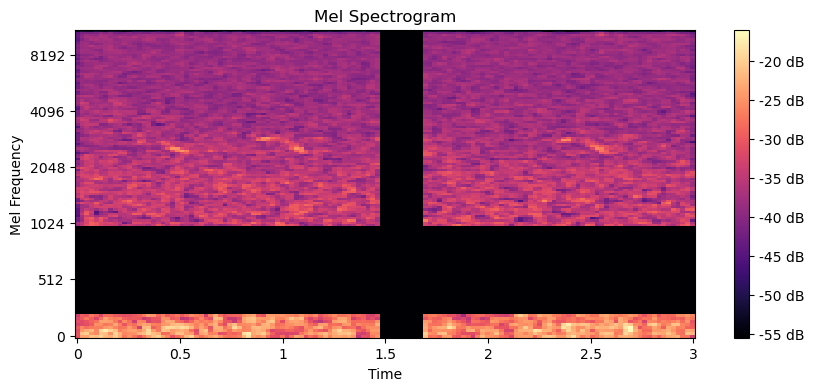

In [ ]:

# Carica audio e crea mel spectrogram
audio, sr = librosa.load("E:/Giacomo/Tovanella/all_segments_5/train/Erithacus rubecula_European Robin/20190608_180000_139.wav")
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram)
vmin = np.min(mel_spectrogram_db)
vmax = np.max(mel_spectrogram_db)

mel_specaugm = spec_augment(mel_spectrogram)
mel_specaugm_db = librosa.power_to_db(mel_specaugm)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_specaugm_db, sr=sr, x_axis="time", y_axis="mel", vmin=vmin, vmax=vmax)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.show()


In [ ]:
# Converti lo spettrogramma Mel modificato in audio
audio_reconstructed = librosa.feature.inverse.mel_to_audio(mel_specaugm, sr=sr)

# Salva il file WAV
sf.write("output_augmented.wav", audio_reconstructed, sr)

print("File audio generato: output_augmented.wav")


File audio generato: output_augmented.wav
